In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split

from datetime import datetime
import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import isBtoDstlnu, whichBisSig, customMCmatching, B_ID, whichBisSig_NAHS, D0_decay_type

In [2]:
root_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/BASF2_performance_GiannasScript/GiannasScript_wNNcuts_D0fixed/"

## load root files

In [3]:
fileY4S = uproot.open(root_path + "DXtagDstl.root:variables")
df_Y4S = fileY4S.arrays(library="pd")

In [4]:
names = ["gammas","electrons","pions","kaons","muons"]
dfs = []
for name in names:
    filename = root_path + "{}.root:variables".format(name)
    print(filename)
    tmpFileFSPs = uproot.open(filename)
    df_tmp = tmpFileFSPs.arrays(library="pd")
    dfs.append(df_tmp)
df_FSPs = pd.concat(dfs)

/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/BASF2_performance_GiannasScript/GiannasScript_wNNcuts_D0fixed/gammas.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/BASF2_performance_GiannasScript/GiannasScript_wNNcuts_D0fixed/electrons.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/BASF2_performance_GiannasScript/GiannasScript_wNNcuts_D0fixed/pions.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/BASF2_performance_GiannasScript/GiannasScript_wNNcuts_D0fixed/kaons.root:variables
/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/BASF2_performance_GiannasScript/GiannasScript_wNNcuts_D0fixed/muons.root:variables


In [5]:
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])

94683
4777


In [6]:
df_Y4S = df_Y4S[(df_Y4S['Hc_isSignalAcceptMissingGamma'] == 1.0)]
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Y4S["__event__"])]

In [7]:
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])

94683
4777


## filter for the wanted D0 modes

In [8]:
df_Y4S['Bsig_uniqParID'] = df_Y4S.apply(whichBisSig_NAHS, axis=1)

In [9]:
df_Y4S['D0_decay'] = df_Y4S.apply(D0_decay_type, axis=1)
df_Y4S = df_Y4S[df_Y4S['D0_decay'] != "notWanted"]

In [10]:
df_Y4S = df_Y4S[((df_Y4S["Bsig_uniqParID"] == 83886081.0)  &
            (df_Y4S["genUp4S_PDG_0_0_0"].abs() == 421.0)  & # 421=D0
            (df_Y4S["genUp4S_PDG_0_0_1"].abs() == 211.0)  & # 211=pion
            (df_Y4S["genUp4S_PDG_0_0_2"].isna() == True)   # no particle 
              |
        ((df_Y4S["Bsig_uniqParID"] == 83886082.0)  &
            (df_Y4S["genUp4S_PDG_1_0_0"].abs() == 421.0)  & # 421=D0
            (df_Y4S["genUp4S_PDG_1_0_1"].abs() == 211.0)  & # 211=pion
            (df_Y4S["genUp4S_PDG_1_0_2"].isna() == True)))] # no particle 

In [11]:
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Y4S["__event__"])]
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])

58944
3073


## delete evts where Bsig and Hc mother are the same

In [12]:
df_Y4S = df_Y4S[(df_Y4S["Hc_motherUniqParID"]==83886082.0) | (df_Y4S["Hc_motherUniqParID"]==83886081.0)]

In [13]:
df_Y4S = df_Y4S[df_Y4S["Bsig_uniqParID"] != df_Y4S["Hc_motherUniqParID"]]

In [14]:
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(df_Y4S["__event__"])]
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])

33896
1776


## take care of duplis in particle lists

In [15]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    33896
dtype: int64

In [16]:
# delete particles which occur more than ones (keep first) and if possible keep the one with basf2_used==1
print("df_FSPs[basf2_used].value_counts():",df_FSPs["basf2_used"].value_counts())
df_FSPs = df_FSPs.sort_values("basf2_used",ascending=False).drop_duplicates(subset=("__event__","uniqueParticleIdentifier"), keep='first')
print("df_FSPs[basf2_used].value_counts():",df_FSPs["basf2_used"].value_counts())

df_FSPs[basf2_used].value_counts(): 1.0    28692
0.0     5204
Name: basf2_used, dtype: int64
df_FSPs[basf2_used].value_counts(): 1.0    28692
0.0     5204
Name: basf2_used, dtype: int64


In [17]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    33896
dtype: int64

## delete Hc particles

In [18]:
df_FSPs = df_FSPs[~((df_FSPs["basf2_used"]== 1) & (df_FSPs["basf2_Bsig"]== 0) & (df_FSPs["basf2_X"]== 0))]

In [19]:
numFSPs = pd.DataFrame({'numFSPs' : df_FSPs.groupby(["__event__"]).size()}).reset_index()

In [20]:
numFSPs["numFSPs"].describe()

count    1776.000000
mean       16.188626
std         4.120974
min         5.000000
25%        13.000000
50%        16.000000
75%        19.000000
max        32.000000
Name: numFSPs, dtype: float64

## add the basf2 label

In [21]:
def basf2_label(s):
    label = 0
 
    if s["basf2_X"] == 1.0:
        label = 1 # particle belongs to X 
    elif s["basf2_Bsig"] == 1.0:
        label = 2 # particle belongs to Bsig 
    elif s["basf2_used"] == 0.0:
        label = 0 # background  
        
    return label

In [22]:
df_FSPs['basf2_label'] = df_FSPs.apply(basf2_label, axis=1)

In [23]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        event_num = (s['__event__'])
        B_sigID = df_Y4S[df_Y4S['__event__'] == event_num].iloc[0]['Bsig_uniqParID']
        
        if int(s['B_ID']) == B_sigID:
            label = 2 # Bsig
        else:
            label = 1 #X
    return label

In [24]:
df_FSPs['B_ID'] = df_FSPs.apply(B_ID, axis=1)

In [25]:
df_FSPs['label'] = df_FSPs.apply(labels, axis=1)

In [26]:
df_FSPs['basf2_correct'] = (df_FSPs['basf2_label'] == df_FSPs['label'])

In [27]:
df_FSPs['basf2_correct'].describe()

count     28751
unique        2
top        True
freq      20631
Name: basf2_correct, dtype: object

## delete top num particle evts

In [28]:
numberFSPsEvts = pd.DataFrame({'count' : df_FSPs.groupby(["__event__"]).size()}).reset_index()
numEvtsBeforeCut = df_Y4S.shape[0]

In [29]:
# print first to adjust percentile used
print("original max FSPs:",numberFSPsEvts["count"].max())
for percentile_lvl in [0.995,0.996,0.997,0.998,0.999]:
    print(percentile_lvl)
    percentile = numberFSPsEvts["count"].quantile(q=percentile_lvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    #TMP_df_FSPs = df_FSPs[df_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    TMP_df_Hc = df_Y4S[df_Y4S['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
    print("would delete", round(100 - (TMP_df_Hc.shape[0]/df_Y4S.shape[0])*100,2),"% of evts")
    print("new max FSPs:",cut_numberFSPsEvts["count"].max())

original max FSPs: 32
0.995
would delete 0.79 % of evts
new max FSPs: 26
0.996
would delete 0.79 % of evts
new max FSPs: 26
0.997
would delete 0.79 % of evts
new max FSPs: 26
0.998
would delete 0.28 % of evts
new max FSPs: 27
0.999
would delete 0.11 % of evts
new max FSPs: 30


In [31]:
delete_top_numFSP_evts = True

In [32]:
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])


if delete_top_numFSP_evts:
    delete_percentileLvl = 0.997
    print("used delete_percentileLvl:",delete_percentileLvl)
    
    
    print(numberFSPsEvts["count"].describe())
    
    percentile = numberFSPsEvts["count"].quantile(q=delete_percentileLvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    df_FSPs = df_FSPs[df_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    df_Y4S = df_Y4S[df_Y4S['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
print(df_FSPs.shape[0])
print(df_Y4S.shape[0])
print("deleted", round(100 - (df_Y4S.shape[0]/numEvtsBeforeCut)*100,4),"% of events")
numberFSPsEvts = pd.DataFrame({'count' : df_FSPs.groupby(["__event__"]).size()}).reset_index()
print(numberFSPsEvts["count"].describe())

28751
1776
used delete_percentileLvl: 0.997
count    1776.000000
mean       16.188626
std         4.120974
min         5.000000
25%        13.000000
50%        16.000000
75%        19.000000
max        32.000000
Name: count, dtype: float64
28359
1762
deleted 0.7883 % of events
count    1762.000000
mean       16.094779
std         3.997243
min         5.000000
25%        13.000000
50%        16.000000
75%        19.000000
max        26.000000
Name: count, dtype: float64


## save df's

In [33]:
df_FSPs.to_csv(root_path + "FSPs_preProcessed_basf2Perf.csv")
df_Y4S.to_csv(root_path + "Y4S_preProcessed_basf2Perf.csv")

## load df's

In [3]:
df_FSPs = pd.read_csv(root_path + "FSPs_preProcessed_basf2Perf.csv")
df_Y4S = pd.read_csv(root_path + "Y4S_preProcessed_basf2Perf.csv")

In [5]:
df_Y4S["D0_decay"].value_counts()

Kpipi0        924
Kpi           445
Kpipipi       270
Kpipipipi0    123
Name: D0_decay, dtype: int64

## plot num particles

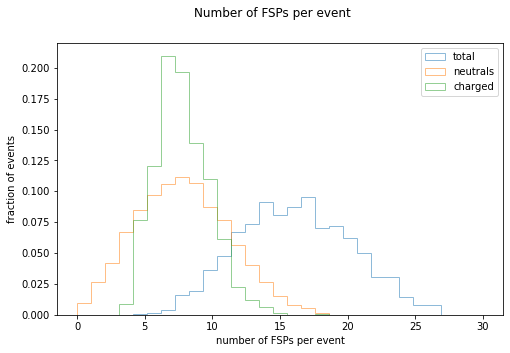

In [4]:
bins = np.linspace(0, 30, 30)
neutrals = df_FSPs[df_FSPs["PDG"] == 22.]
charged = df_FSPs[df_FSPs["PDG"] != 22.]

numFSPs_all = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numFSPs_charged = pd.DataFrame({'count' : charged.groupby( ["__event__"] ).size()}).reset_index()
numFSPs_neutral = pd.DataFrame({'count' : neutrals.groupby( ["__event__"] ).size()}).reset_index()


fig, ax = plt.subplots()
fig.suptitle(r'Number of FSPs per event')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of FSPs per event')
ax.set_ylabel("fraction of events")

ax.hist(numFSPs_all["count"],bins=bins,density=True, alpha=0.5, label=(r'total'),histtype='step')
ax.hist(numFSPs_neutral["count"],bins=bins,density=True, alpha=0.5, label=(r'neutrals'),histtype='step')
ax.hist(numFSPs_charged["count"],bins=bins,density=True, alpha=0.5, label=(r'charged'),histtype='step')

ax.legend(loc='upper right')


plt.savefig('numFSPs_Gmodes_basf2Performance_D0fixed.pdf')

In [40]:
numFSPs_all = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numFSPs_all["count"].describe()

count    1762.000000
mean       16.094779
std         3.997243
min         5.000000
25%        13.000000
50%        16.000000
75%        19.000000
max        26.000000
Name: count, dtype: float64

## check the assignment accuracy of basf2

In [35]:
groupsAllFSPs = pd.DataFrame({'count' : df_FSPs.groupby(["label","basf2_label"]).size()}).reset_index()
groupsAllFSPs

,label,basf2_label,count
0,0,0,1893
1,0,1,2061
2,0,2,273
3,1,0,2592
4,1,1,9846
5,1,2,1032
6,2,0,627
7,2,1,1370
8,2,2,8665


In [36]:
print("accuracy of basf2 for all particles:",round(df_FSPs[df_FSPs["basf2_correct"] == True].shape[0] / df_FSPs.shape[0] *100,2),'%')

accuracy of basf2 for all particles: 71.95 %


In [29]:
numFSPs.shape[0]

1693

In [37]:
groupsAllFSPs = pd.DataFrame({'corrects' : df_FSPs.groupby( ["__event__","basf2_correct"] ).size()}).reset_index()
basf2_failureCount = groupsAllFSPs[groupsAllFSPs["basf2_correct"] == True]

numFSPs = pd.DataFrame({'numFSPs' : df_FSPs.groupby(["__event__"]).size()}).reset_index()

basf2_stats = pd.merge(basf2_failureCount[["__event__","corrects"]],numFSPs[["__event__","numFSPs"]], on="__event__")


basf2_stats

,__event__,corrects,numFSPs
0,579,14,25
1,56345,12,19
2,59093,16,19
3,61733,15,18
4,134598,8,11
...,...,...,...
1757,50819999,12,14
1758,50839237,9,11
1759,50845012,15,17
1760,50864508,14,16


In [38]:
basf2_stats["wrongs"] = basf2_stats["numFSPs"] - basf2_stats["corrects"] 
basf2_stats

,__event__,corrects,numFSPs,wrongs
0,579,14,25,11
1,56345,12,19,7
2,59093,16,19,3
3,61733,15,18,3
4,134598,8,11,3
...,...,...,...,...
1757,50819999,12,14,2
1758,50839237,9,11,2
1759,50845012,15,17,2
1760,50864508,14,16,2


In [ ]:
bins = np.linspace(0, 30, 30)
fig, ax = plt.subplots()
fig.suptitle(r'----')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of wrong assignments per event')
ax.set_ylabel("fraction of total events")

ax.hist(basf2_stats["wrongs"],bins=bins,density=True, alpha=0.5, label=(r'---'),histtype='step')
#ax.hist(numFSPs_charged["count"],bins=bins,density=True, alpha=0.5, label=(r'charged'),histtype='step')
#ax.hist(numFSPs["count"],bins=bins,density=True, alpha=0.5, label=(r'total'),histtype='step')




ax.legend(loc='upper right')

#plt.savefig('dataSetAnaPlots/numFSPs_histo_NAHSrun1_neutrals_charged.pdf')

In [39]:
print("accuracy of basf2 for all particles:",round(df_FSPs[df_FSPs["basf2_correct"] == True].shape[0] / df_FSPs.shape[0] *100,2),'%')

print("BASF2 assignment errors per event \n")

numEvts = basf2_stats.shape[0]
for i in range(4):
    print(i, 'errors:', round(basf2_stats[basf2_stats["wrongs"] == i].shape[0]  /  numEvts * 100, 2),'%')

i = 3
print('more than',i, 'errors:', round(basf2_stats[basf2_stats["wrongs"] > i].shape[0]  /  numEvts * 100, 2),'%')

accuracy of basf2 for all particles: 71.95 %
BASF2 assignment errors per event 

0 errors: 3.52 %
1 errors: 9.25 %
2 errors: 15.04 %
3 errors: 14.81 %
more than 3 errors: 57.38 %


In [52]:
basf2_stats["wrongs"].describe()

count    51177.000000
mean         7.330129
std          3.737335
min          0.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         22.000000
Name: wrongs, dtype: float64